# STEP 1: Environment Setup

In [15]:
# STEP 1: Environment Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Custom modules
from src.data_manager import load_and_split_dataset
from src.sift_processor import extract_sift_descriptors
from src.lbp_processor import extract_lbp_descriptors
from src.bow_encoder import build_visual_dictionary, transform_to_bow
from src.feature_fusion import extract_rgb_histogram, augment_image

# STEP 2: Load and split dataset

In [16]:
# STEP 2: Load and Split Dataset
# - Uses 50% sample of the full dataset and 20% of that for testing
train_paths, train_labels, test_paths, test_labels, class_names = load_and_split_dataset(
    root_folder="../Aerial_Landscapes", test_ratio=0.2, sample_ratio=0.5, random_seed=42
)

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"✅ Dataset loaded successfully.")
print(f"Training samples: {len(train_paths)}")
print(f"Testing samples : {len(test_paths)}")

✅ Dataset loaded successfully.
Training samples: 4800
Testing samples : 1200


# STEP 3: Training and Evaluation Pipeline

In [17]:
# STEP 3: Define Classifier Dictionary
SEED = 42
models = {
    "SVM_RBF": SVC(kernel='rbf', C=10, gamma='scale', random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=SEED),
    "XGBoost": xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1,
                                 eval_metric='mlogloss', random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# STEP 4: SIFT Feature Extraction (BoW only + ColorHist + Aug)

In [18]:
# STEP 4: Extract SIFT Features (BoW only + ColorHist + Aug)
# Build vocabulary from plain SIFT
sift_desc_all = extract_sift_descriptors(train_paths, augmentation_fn=None)
kmeans_model_sift = build_visual_dictionary(sift_desc_all, cluster_count=300, max_sample=15000, seed=SEED)

# BoW only
sift_train_plain = extract_sift_descriptors(train_paths, augmentation_fn=None)
sift_test_plain = extract_sift_descriptors(test_paths, augmentation_fn=None)
X_train_sift_plain = transform_to_bow(sift_train_plain, kmeans_model_sift)
X_test_sift_plain = transform_to_bow(sift_test_plain, kmeans_model_sift)

# BoW + ColorHist + Aug
sift_train_aug = extract_sift_descriptors(train_paths, augmentation_fn=augment_image)
sift_test_aug = extract_sift_descriptors(test_paths, augmentation_fn=None)
bow_train_sift_full = transform_to_bow(sift_train_aug, kmeans_model_sift)
bow_test_sift_full = transform_to_bow(sift_test_aug, kmeans_model_sift)
hist_train_sift = np.array([extract_rgb_histogram(p) for p in train_paths])
hist_test_sift = np.array([extract_rgb_histogram(p) for p in test_paths])
X_train_sift_full = np.hstack((bow_train_sift_full, hist_train_sift))
X_test_sift_full = np.hstack((bow_test_sift_full, hist_test_sift))

# STEP 5: LBP Feature Extraction (BoW only + ColorHist + Aug)

In [19]:
# STEP 5: Extract LBP Features (BoW only + ColorHist + Aug)
# Build LBP vocabulary
lbp_desc_all = extract_lbp_descriptors(train_paths, augmentation_fn=None)
kmeans_model_lbp = build_visual_dictionary(lbp_desc_all, cluster_count=300, max_sample=15000, seed=SEED)

# BoW only
lbp_train_plain = extract_lbp_descriptors(train_paths, augmentation_fn=None)
lbp_test_plain = extract_lbp_descriptors(test_paths, augmentation_fn=None)
X_train_lbp_plain = transform_to_bow(lbp_train_plain, kmeans_model_lbp)
X_test_lbp_plain = transform_to_bow(lbp_test_plain, kmeans_model_lbp)

# BoW + ColorHist + Aug
lbp_train_aug = extract_lbp_descriptors(train_paths, augmentation_fn=augment_image)
lbp_test_aug = extract_lbp_descriptors(test_paths, augmentation_fn=None)
bow_train_lbp_full = transform_to_bow(lbp_train_aug, kmeans_model_lbp)
bow_test_lbp_full = transform_to_bow(lbp_test_aug, kmeans_model_lbp)
hist_train_lbp = np.array([extract_rgb_histogram(p) for p in train_paths])
hist_test_lbp = np.array([extract_rgb_histogram(p) for p in test_paths])
X_train_lbp_full = np.hstack((bow_train_lbp_full, hist_train_lbp))
X_test_lbp_full = np.hstack((bow_test_lbp_full, hist_test_lbp))

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommend

# STEP 6: Classification (BoW Only, no augmentation, no color histogram)

🔍 Training: SIFT_plain + SVM_RBF
              precision    recall  f1-score   support

 Agriculture       0.68      0.70      0.69        80
     Airport       0.67      0.69      0.68        80
       Beach       0.69      0.59      0.64        80
        City       0.72      0.75      0.74        80
      Desert       0.64      0.59      0.61        80
      Forest       0.87      0.89      0.88        80
   Grassland       0.52      0.76      0.62        80
     Highway       0.64      0.57      0.61        80
        Lake       0.41      0.36      0.39        80
    Mountain       0.80      0.85      0.82        80
     Parking       0.99      0.94      0.96        80
        Port       0.82      0.75      0.78        80
     Railway       0.67      0.74      0.70        80
 Residential       0.86      0.90      0.88        80
       River       0.42      0.34      0.37        80

    accuracy                           0.69      1200
   macro avg       0.69      0.69      0.69    

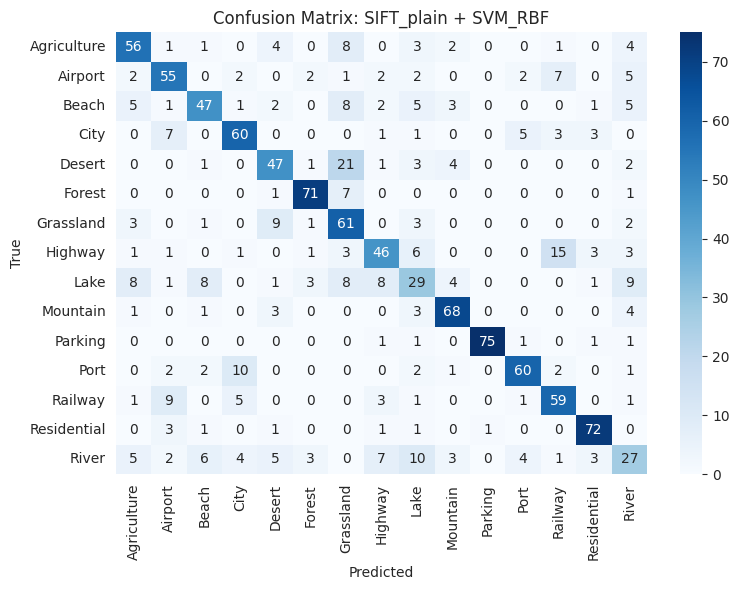

🔍 Training: SIFT_plain + RandomForest
              precision    recall  f1-score   support

 Agriculture       0.65      0.65      0.65        80
     Airport       0.52      0.53      0.52        80
       Beach       0.60      0.62      0.61        80
        City       0.63      0.71      0.67        80
      Desert       0.59      0.60      0.59        80
      Forest       0.74      0.86      0.80        80
   Grassland       0.58      0.60      0.59        80
     Highway       0.48      0.54      0.51        80
        Lake       0.56      0.24      0.33        80
    Mountain       0.65      0.80      0.72        80
     Parking       0.91      0.89      0.90        80
        Port       0.76      0.66      0.71        80
     Railway       0.59      0.65      0.62        80
 Residential       0.71      0.90      0.79        80
       River       0.36      0.21      0.27        80

    accuracy                           0.63      1200
   macro avg       0.62      0.63      0.6

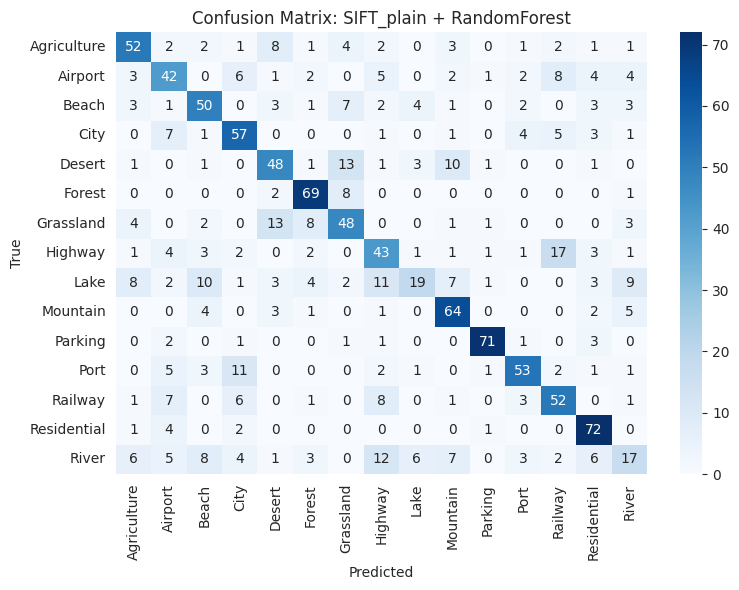

🔍 Training: SIFT_plain + XGBoost
              precision    recall  f1-score   support

 Agriculture       0.67      0.65      0.66        80
     Airport       0.67      0.56      0.61        80
       Beach       0.63      0.65      0.64        80
        City       0.67      0.68      0.67        80
      Desert       0.60      0.66      0.63        80
      Forest       0.86      0.84      0.85        80
   Grassland       0.62      0.62      0.62        80
     Highway       0.53      0.54      0.53        80
        Lake       0.44      0.40      0.42        80
    Mountain       0.83      0.75      0.79        80
     Parking       0.90      0.89      0.89        80
        Port       0.83      0.75      0.79        80
     Railway       0.65      0.74      0.69        80
 Residential       0.80      0.86      0.83        80
       River       0.40      0.45      0.42        80

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67    

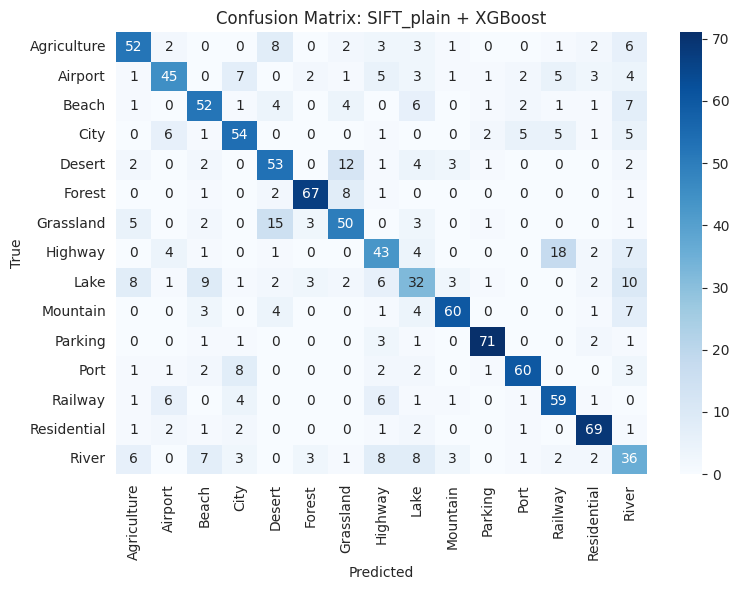

🔍 Training: SIFT_plain + KNN
              precision    recall  f1-score   support

 Agriculture       0.53      0.54      0.53        80
     Airport       0.39      0.50      0.44        80
       Beach       0.68      0.26      0.38        80
        City       0.41      0.80      0.54        80
      Desert       0.61      0.45      0.52        80
      Forest       0.74      0.94      0.82        80
   Grassland       0.82      0.41      0.55        80
     Highway       0.45      0.34      0.39        80
        Lake       0.35      0.34      0.34        80
    Mountain       0.58      0.81      0.67        80
     Parking       0.93      0.84      0.88        80
        Port       0.90      0.34      0.49        80
     Railway       0.44      0.74      0.55        80
 Residential       0.66      0.82      0.73        80
       River       0.36      0.19      0.25        80

    accuracy                           0.55      1200
   macro avg       0.59      0.55      0.54      12

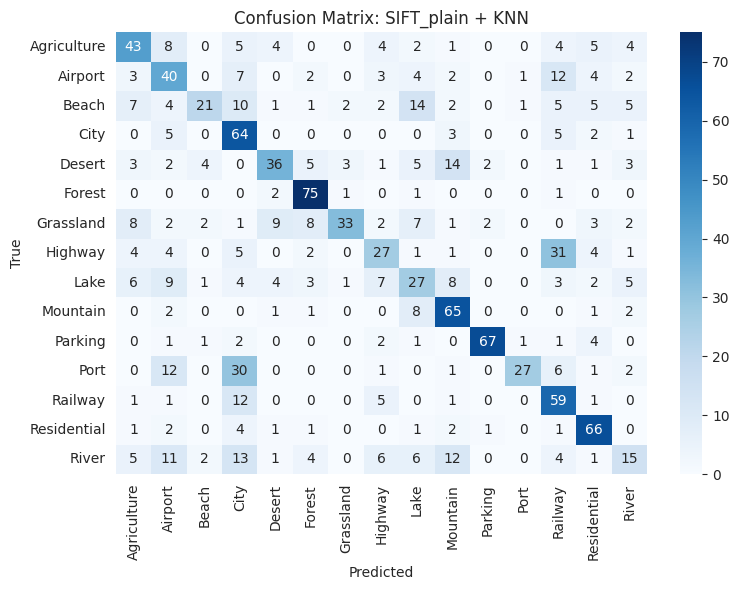

🔍 Training: LBP_plain + SVM_RBF
              precision    recall  f1-score   support

 Agriculture       0.44      0.36      0.40        80
     Airport       0.27      0.24      0.25        80
       Beach       0.32      0.29      0.30        80
        City       0.31      0.33      0.32        80
      Desert       0.48      0.39      0.43        80
      Forest       0.70      0.64      0.67        80
   Grassland       0.56      0.59      0.57        80
     Highway       0.50      0.29      0.37        80
        Lake       0.41      0.46      0.44        80
    Mountain       0.34      0.56      0.43        80
     Parking       0.45      0.41      0.43        80
        Port       0.56      0.54      0.55        80
     Railway       0.36      0.33      0.34        80
 Residential       0.40      0.60      0.48        80
       River       0.21      0.20      0.21        80

    accuracy                           0.41      1200
   macro avg       0.42      0.41      0.41     

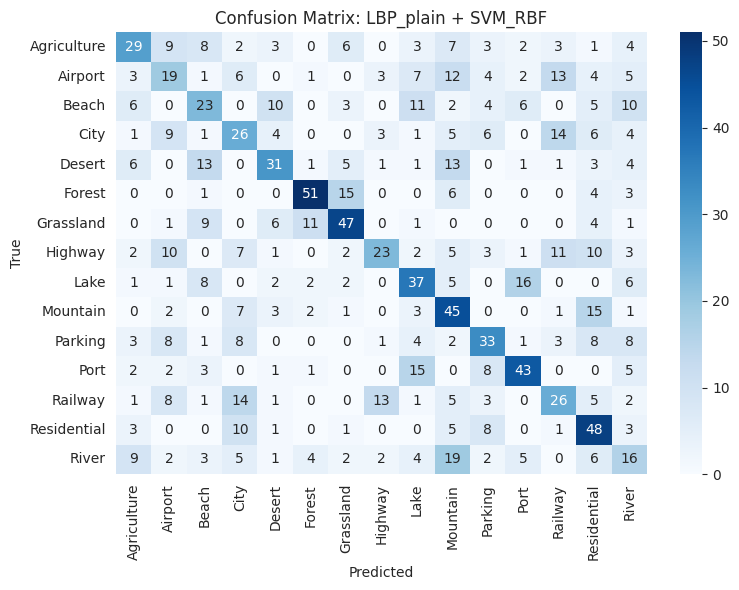

🔍 Training: LBP_plain + RandomForest
              precision    recall  f1-score   support

 Agriculture       0.46      0.39      0.42        80
     Airport       0.22      0.20      0.21        80
       Beach       0.34      0.29      0.31        80
        City       0.30      0.33      0.31        80
      Desert       0.49      0.39      0.43        80
      Forest       0.55      0.74      0.63        80
   Grassland       0.59      0.55      0.57        80
     Highway       0.46      0.29      0.35        80
        Lake       0.41      0.44      0.42        80
    Mountain       0.34      0.56      0.43        80
     Parking       0.43      0.39      0.41        80
        Port       0.52      0.53      0.52        80
     Railway       0.36      0.33      0.34        80
 Residential       0.41      0.55      0.47        80
       River       0.22      0.17      0.20        80

    accuracy                           0.41      1200
   macro avg       0.41      0.41      0.40

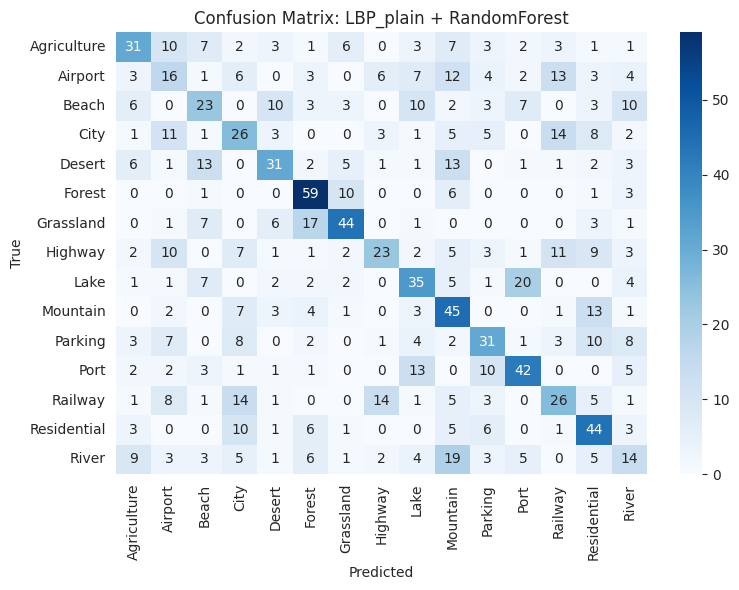

🔍 Training: LBP_plain + XGBoost
              precision    recall  f1-score   support

 Agriculture       0.36      0.30      0.33        80
     Airport       0.28      0.26      0.27        80
       Beach       0.27      0.35      0.31        80
        City       0.30      0.36      0.33        80
      Desert       0.55      0.39      0.46        80
      Forest       0.64      0.70      0.67        80
   Grassland       0.59      0.46      0.52        80
     Highway       0.50      0.29      0.37        80
        Lake       0.44      0.40      0.42        80
    Mountain       0.34      0.59      0.43        80
     Parking       0.48      0.31      0.38        80
        Port       0.58      0.47      0.52        80
     Railway       0.35      0.31      0.33        80
 Residential       0.39      0.62      0.48        80
       River       0.22      0.21      0.22        80

    accuracy                           0.40      1200
   macro avg       0.42      0.40      0.40     

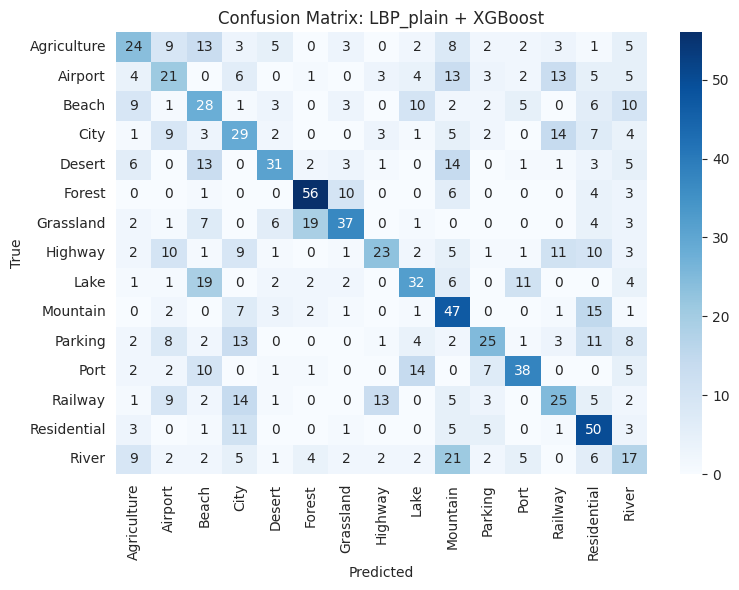

🔍 Training: LBP_plain + KNN
              precision    recall  f1-score   support

 Agriculture       0.17      0.66      0.27        80
     Airport       0.15      0.40      0.22        80
       Beach       0.17      0.44      0.24        80
        City       0.31      0.39      0.34        80
      Desert       0.20      0.26      0.23        80
      Forest       0.57      0.71      0.63        80
   Grassland       0.62      0.16      0.26        80
     Highway       0.37      0.16      0.23        80
        Lake       0.39      0.35      0.37        80
    Mountain       0.00      0.00      0.00        80
     Parking       0.45      0.12      0.20        80
        Port       0.71      0.06      0.11        80
     Railway       0.00      0.00      0.00        80
 Residential       0.00      0.00      0.00        80
       River       0.00      0.00      0.00        80

    accuracy                           0.25      1200
   macro avg       0.27      0.25      0.21      120

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

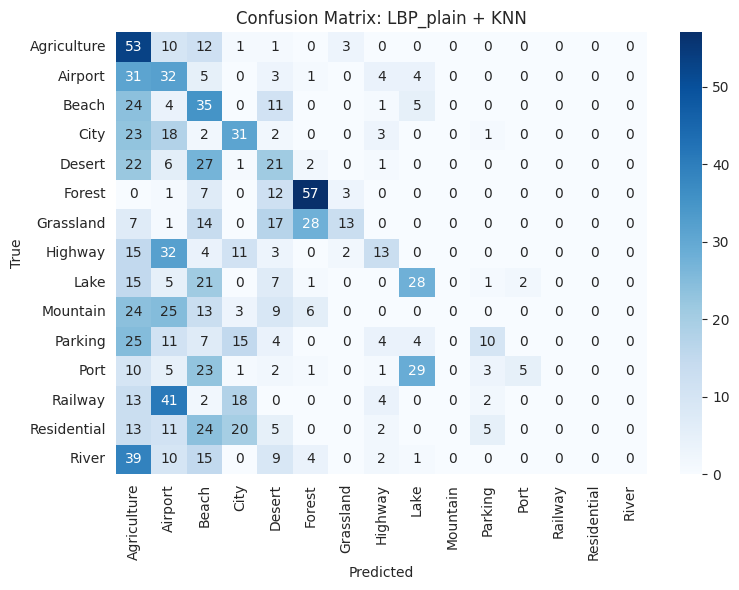

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [20]:
# STEP 6: Train & Evaluate - BoW Only (SIFT / LBP)
results_plain = []
for feature_tag, X_train_feat, X_test_feat in [
    ("SIFT_plain", X_train_sift_plain, X_test_sift_plain),
    ("LBP_plain", X_train_lbp_plain, X_test_lbp_plain)
]:
    for model_name, model in models.items():
        print(f"🔍 Training: {feature_tag} + {model_name}")
        model.fit(X_train_feat, y_train)

        start = time.time()
        y_pred = model.predict(X_test_feat)
        test_time = time.time() - start

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=class_names)
        print(report)

        # 混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix: {feature_tag} + {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        report_dict = classification_report(y_test, y_pred, output_dict=True)
        results_plain.append({
            "Feature": feature_tag,
            "Model": model_name,
            "Accuracy": f"{acc*100:.2f}%",
            "F1": round(report_dict["weighted avg"]["f1-score"], 3),
            "Precision": round(report_dict["weighted avg"]["precision"], 3),
            "Recall": round(report_dict["weighted avg"]["recall"], 3),
            "Test Time (s)": round(test_time, 3),
            "Setting": "BoW Only"
        })

# STEP 7: Classification (BoW + Color Histogram + Augmentation)

🔍 Training: SIFT_full + SVM_RBF
              precision    recall  f1-score   support

 Agriculture       0.61      0.72      0.66        80
     Airport       0.55      0.60      0.57        80
       Beach       0.80      0.71      0.75        80
        City       0.74      0.70      0.72        80
      Desert       0.90      0.86      0.88        80
      Forest       0.83      0.94      0.88        80
   Grassland       0.76      0.85      0.80        80
     Highway       0.64      0.59      0.61        80
        Lake       0.74      0.56      0.64        80
    Mountain       0.76      0.81      0.78        80
     Parking       0.88      0.82      0.85        80
        Port       0.86      0.88      0.87        80
     Railway       0.60      0.78      0.68        80
 Residential       0.80      0.75      0.77        80
       River       0.66      0.50      0.57        80

    accuracy                           0.74      1200
   macro avg       0.74      0.74      0.74     

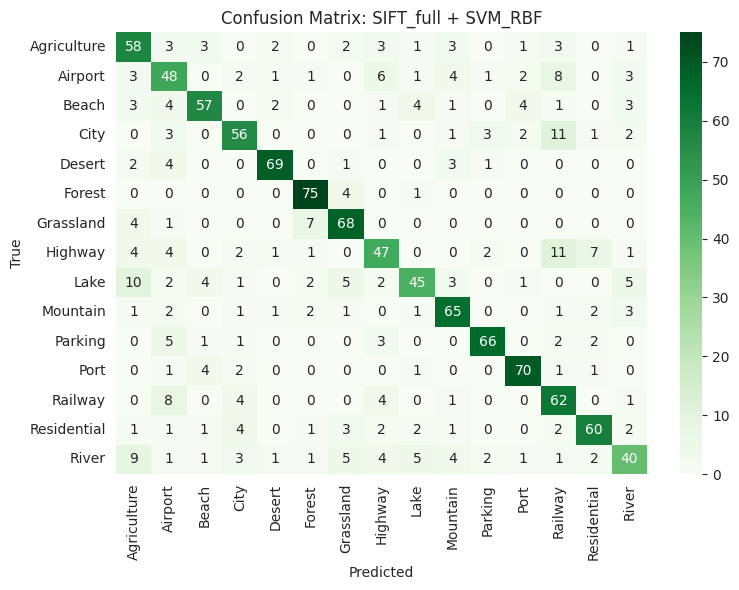

🔍 Training: SIFT_full + RandomForest
              precision    recall  f1-score   support

 Agriculture       0.69      0.65      0.67        80
     Airport       0.62      0.61      0.62        80
       Beach       0.84      0.79      0.81        80
        City       0.79      0.51      0.62        80
      Desert       0.89      0.89      0.89        80
      Forest       0.71      0.99      0.82        80
   Grassland       0.80      0.76      0.78        80
     Highway       0.51      0.65      0.57        80
        Lake       0.62      0.35      0.45        80
    Mountain       0.67      0.82      0.74        80
     Parking       0.85      0.88      0.86        80
        Port       0.81      0.72      0.76        80
     Railway       0.58      0.74      0.65        80
 Residential       0.73      0.88      0.80        80
       River       0.62      0.42      0.50        80

    accuracy                           0.71      1200
   macro avg       0.72      0.71      0.70

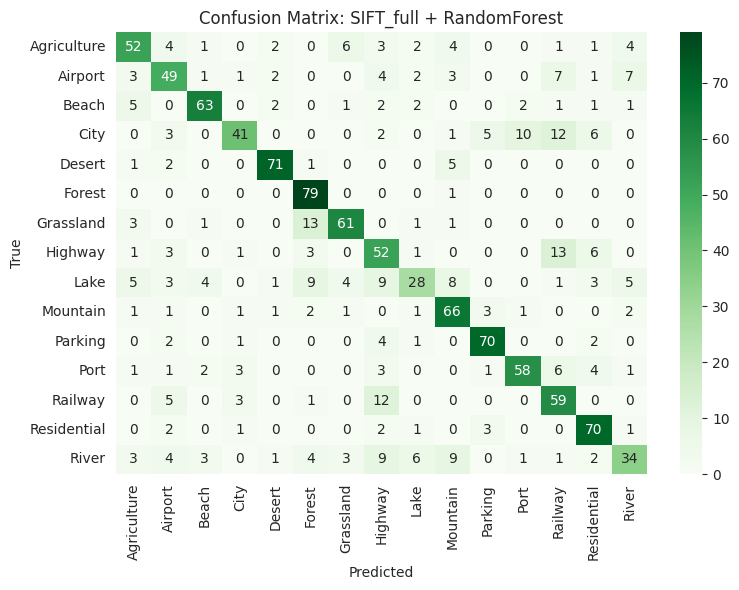

🔍 Training: SIFT_full + XGBoost
              precision    recall  f1-score   support

 Agriculture       0.82      0.76      0.79        80
     Airport       0.65      0.71      0.68        80
       Beach       0.85      0.79      0.82        80
        City       0.86      0.64      0.73        80
      Desert       0.91      0.89      0.90        80
      Forest       0.83      0.97      0.90        80
   Grassland       0.91      0.86      0.88        80
     Highway       0.53      0.71      0.61        80
        Lake       0.70      0.55      0.62        80
    Mountain       0.75      0.81      0.78        80
     Parking       0.86      0.90      0.88        80
        Port       0.85      0.75      0.79        80
     Railway       0.66      0.74      0.70        80
 Residential       0.88      0.82      0.85        80
       River       0.56      0.56      0.56        80

    accuracy                           0.77      1200
   macro avg       0.77      0.77      0.77     

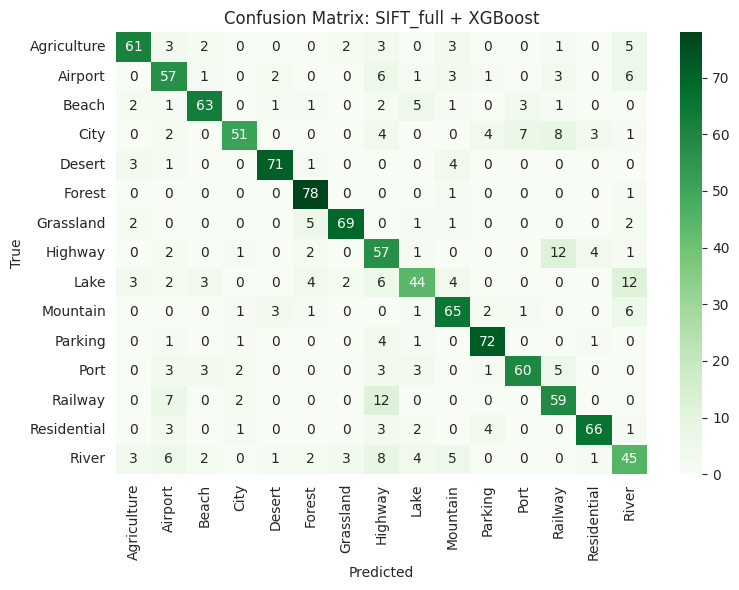

🔍 Training: SIFT_full + KNN
              precision    recall  f1-score   support

 Agriculture       0.34      0.41      0.37        80
     Airport       0.34      0.44      0.38        80
       Beach       0.65      0.44      0.52        80
        City       0.56      0.76      0.65        80
      Desert       0.84      0.85      0.84        80
      Forest       0.67      0.82      0.74        80
   Grassland       0.68      0.79      0.73        80
     Highway       0.33      0.20      0.25        80
        Lake       0.76      0.33      0.46        80
    Mountain       0.49      0.59      0.53        80
     Parking       0.67      0.70      0.68        80
        Port       0.64      0.75      0.69        80
     Railway       0.49      0.53      0.51        80
 Residential       0.60      0.65      0.62        80
       River       0.59      0.25      0.35        80

    accuracy                           0.57      1200
   macro avg       0.58      0.57      0.56      120

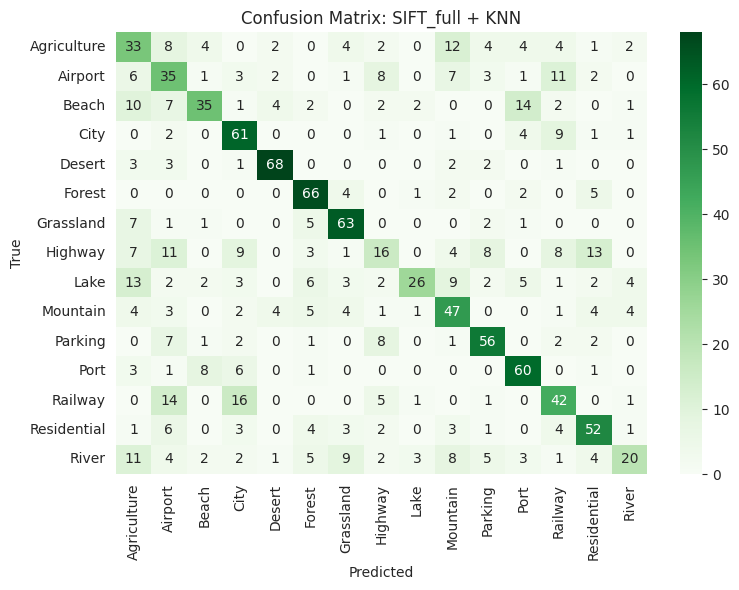

🔍 Training: LBP_full + SVM_RBF
              precision    recall  f1-score   support

 Agriculture       0.38      0.46      0.42        80
     Airport       0.41      0.41      0.41        80
       Beach       0.55      0.71      0.62        80
        City       0.53      0.47      0.50        80
      Desert       0.87      0.85      0.86        80
      Forest       0.70      0.86      0.78        80
   Grassland       0.65      0.88      0.74        80
     Highway       0.34      0.28      0.30        80
        Lake       0.60      0.39      0.47        80
    Mountain       0.63      0.47      0.54        80
     Parking       0.62      0.70      0.66        80
        Port       0.77      0.74      0.75        80
     Railway       0.48      0.50      0.49        80
 Residential       0.67      0.68      0.67        80
       River       0.48      0.34      0.40        80

    accuracy                           0.58      1200
   macro avg       0.58      0.58      0.57      

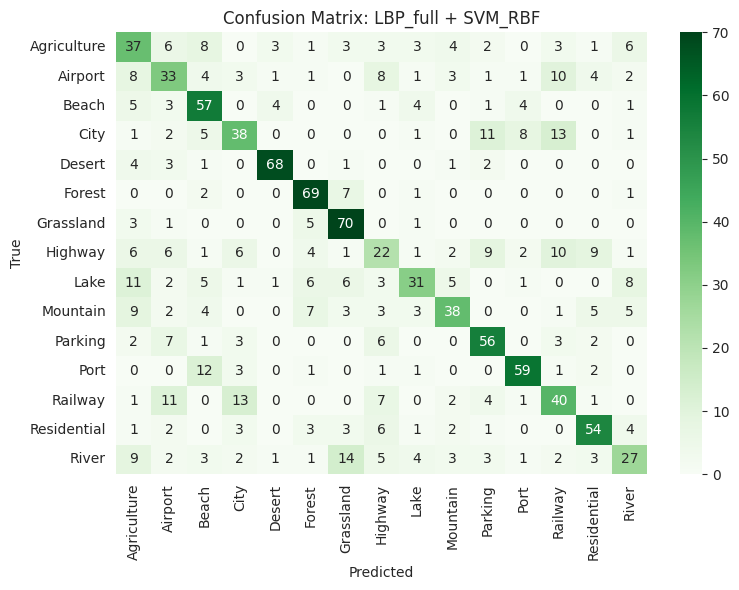

🔍 Training: LBP_full + RandomForest
              precision    recall  f1-score   support

 Agriculture       0.57      0.65      0.61        80
     Airport       0.48      0.60      0.54        80
       Beach       0.71      0.76      0.73        80
        City       0.70      0.59      0.64        80
      Desert       0.87      0.91      0.89        80
      Forest       0.71      0.82      0.76        80
   Grassland       0.76      0.85      0.80        80
     Highway       0.53      0.30      0.38        80
        Lake       0.57      0.46      0.51        80
    Mountain       0.64      0.61      0.63        80
     Parking       0.82      0.81      0.82        80
        Port       0.86      0.76      0.81        80
     Railway       0.52      0.55      0.54        80
 Residential       0.72      0.89      0.80        80
       River       0.60      0.55      0.58        80

    accuracy                           0.68      1200
   macro avg       0.67      0.68      0.67 

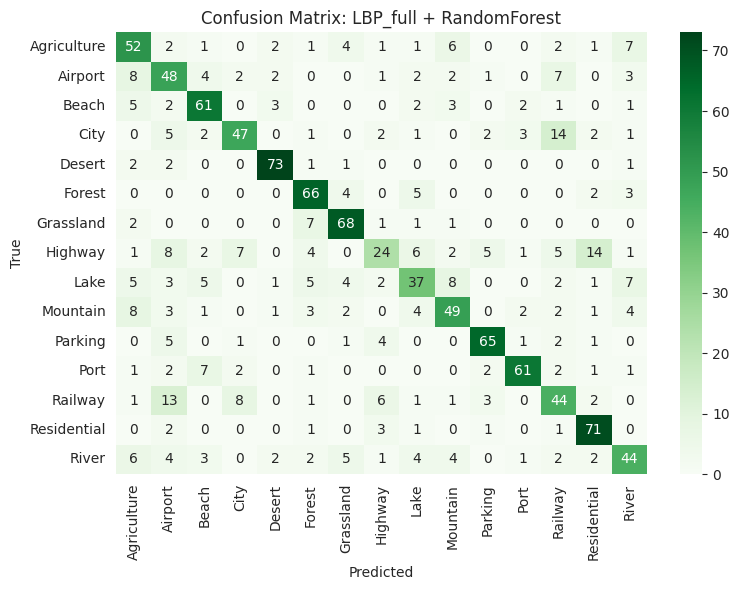

🔍 Training: LBP_full + XGBoost
              precision    recall  f1-score   support

 Agriculture       0.65      0.74      0.69        80
     Airport       0.55      0.57      0.56        80
       Beach       0.75      0.72      0.74        80
        City       0.73      0.61      0.67        80
      Desert       0.91      0.90      0.91        80
      Forest       0.80      0.90      0.85        80
   Grassland       0.84      0.84      0.84        80
     Highway       0.52      0.49      0.50        80
        Lake       0.62      0.55      0.58        80
    Mountain       0.59      0.60      0.59        80
     Parking       0.85      0.84      0.84        80
        Port       0.85      0.79      0.82        80
     Railway       0.54      0.65      0.59        80
 Residential       0.88      0.84      0.86        80
       River       0.59      0.59      0.59        80

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      

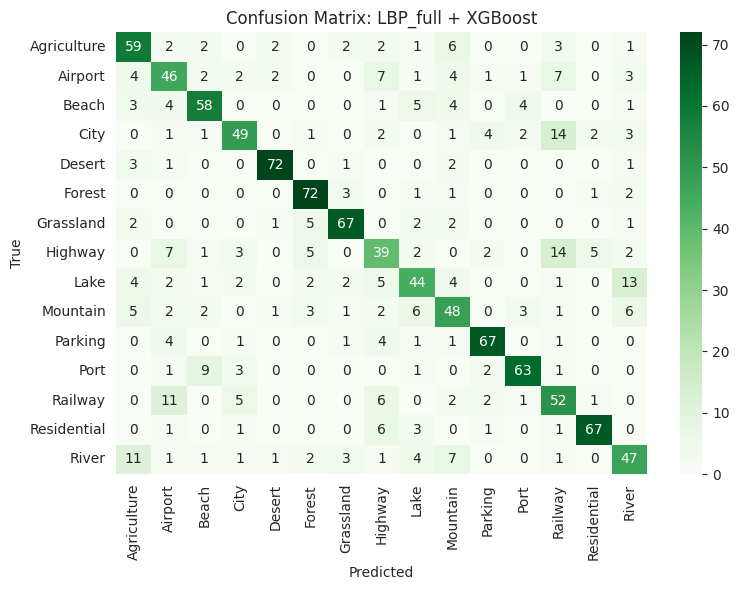

🔍 Training: LBP_full + KNN
              precision    recall  f1-score   support

 Agriculture       0.25      0.35      0.29        80
     Airport       0.30      0.34      0.32        80
       Beach       0.43      0.40      0.42        80
        City       0.49      0.61      0.54        80
      Desert       0.85      0.50      0.63        80
      Forest       0.54      0.88      0.67        80
   Grassland       0.54      0.74      0.62        80
     Highway       0.14      0.11      0.12        80
        Lake       0.44      0.21      0.29        80
    Mountain       0.36      0.25      0.30        80
     Parking       0.49      0.56      0.53        80
        Port       0.68      0.55      0.61        80
     Railway       0.41      0.34      0.37        80
 Residential       0.44      0.65      0.52        80
       River       0.46      0.20      0.28        80

    accuracy                           0.45      1200
   macro avg       0.45      0.45      0.43      1200

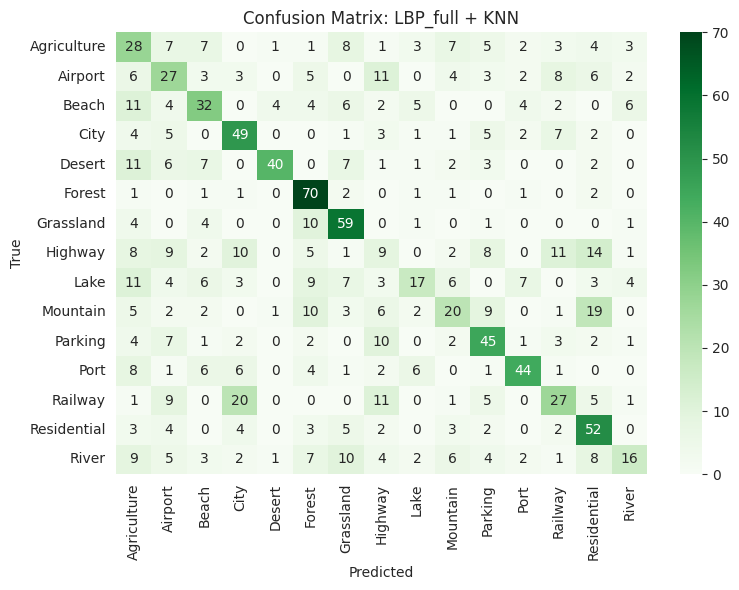

In [21]:
# STEP 7: Train & Evaluate - With ColorHist + Augmentation
results_full = []
for feature_tag, X_train_feat, X_test_feat in [
    ("SIFT_full", X_train_sift_full, X_test_sift_full),
    ("LBP_full", X_train_lbp_full, X_test_lbp_full)
]:
    for model_name, model in models.items():
        print(f"🔍 Training: {feature_tag} + {model_name}")
        model.fit(X_train_feat, y_train)

        start = time.time()
        y_pred = model.predict(X_test_feat)
        test_time = time.time() - start

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=class_names)
        print(report)

        # 混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix: {feature_tag} + {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        report_dict = classification_report(y_test, y_pred, output_dict=True)
        results_full.append({
            "Feature": feature_tag,
            "Model": model_name,
            "Accuracy": f"{acc*100:.2f}%",
            "F1": round(report_dict["weighted avg"]["f1-score"], 3),
            "Precision": round(report_dict["weighted avg"]["precision"], 3),
            "Recall": round(report_dict["weighted avg"]["recall"], 3),
            "Test Time (s)": round(test_time, 3),
            "Setting": "With ColorHist + Aug"
        })

# STEP 8: Combine all results

In [26]:
import pandas as pd

# Convert to DataFrame
df_plain = pd.DataFrame(results_plain)
df_full = pd.DataFrame(results_full)

# Ensure consistent column order
columns = ["Feature", "Model", "Accuracy", "F1", "Precision", "Recall", "Test Time (s)", "Setting"]
df_plain = df_plain[columns]
df_full = df_full[columns]

# 1：BoW Only
print("📄 Results WITHOUT Color Histogram & Augmentation (BoW Only):")
display(df_plain.style.set_caption("BoW Only - SIFT & LBP").format(precision=3))

# 2：With ColorHist + Aug
print("📄 Results WITH Color Histogram & Augmentation:")
display(df_full.style.set_caption("With ColorHist + Aug - SIFT & LBP").format(precision=3))


📄 Results WITHOUT Color Histogram & Augmentation (BoW Only):


📄 Results WITH Color Histogram & Augmentation:


# Export results as markdown table

In [27]:
def format_markdown_table(df):
    headers = "| " + " | ".join(df.columns) + " |"
    separators = "|" + "|".join([":--:" for _ in df.columns]) + "|"
    rows = [
        "| " + " | ".join(str(v) for v in row) + " |"
        for row in df.values
    ]
    return "\n".join([headers, separators] + rows)

#  BoW Only
print("\n📋 Markdown Table - BoW Only:\n")
markdown_plain = format_markdown_table(df_plain)
print(markdown_plain)

#  With ColorHist + Aug
print("\n📋 Markdown Table - With ColorHist + Aug:\n")
markdown_full = format_markdown_table(df_full)
print(markdown_full)



📋 Markdown Table - BoW Only:

| Feature | Model | Accuracy | F1 | Precision | Recall | Test Time (s) | Setting |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| SIFT_plain | SVM_RBF | 69.42% | 0.691 | 0.694 | 0.694 | 1.171 | BoW Only |
| SIFT_plain | RandomForest | 63.08% | 0.618 | 0.621 | 0.631 | 0.035 | BoW Only |
| SIFT_plain | XGBoost | 66.92% | 0.67 | 0.673 | 0.669 | 0.014 | BoW Only |
| SIFT_plain | KNN | 55.42% | 0.539 | 0.589 | 0.554 | 0.06 | BoW Only |
| LBP_plain | SVM_RBF | 41.42% | 0.411 | 0.42 | 0.414 | 0.763 | BoW Only |
| LBP_plain | RandomForest | 40.83% | 0.402 | 0.407 | 0.408 | 0.065 | BoW Only |
| LBP_plain | XGBoost | 40.25% | 0.401 | 0.419 | 0.403 | 0.009 | BoW Only |
| LBP_plain | KNN | 24.83% | 0.206 | 0.274 | 0.248 | 0.049 | BoW Only |

📋 Markdown Table - With ColorHist + Aug:

| Feature | Model | Accuracy | F1 | Precision | Recall | Test Time (s) | Setting |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| SIFT_full | SVM_RBF | 73.83% | 0.737 | 0.742 | 0.738 | 2.629 | 